In [9]:
import jax
import jax.numpy as jnp
import jax.random as jr
import equinox as eqx
import optax
import numpy as np
import matplotlib.pyplot as plt

from typing import Tuple, List, Union, Callable

### DeepONet implementation in Equinox

global seed

In [48]:
SEED = 123

FNN class

In [24]:
class FNN(eqx.Module):
    layers: Tuple
    layer_sizes: List
    activation: Union[List[Callable], Callable]

    """
    Fully-connected Neural Network in Equinox
    """

    def __init__(self, layer_sizes, activation, key, dtype):
        self.layer_sizes = layer_sizes
        # activations
        if isinstance(activation, list):
            if not len(layer_sizes) - 1 == len(activation):
                raise ValueError(f"Total number of activation functions does not match number of layers. Got {len(activation)}, expected {len(layer_sizes)-1}")
            self.activation = activation
        else:
            self.activation = activation
        # keys for layers
        keys = jr.split(key, len(layer_sizes))
        # list of layers
        layers = []
        for i in range(1, len(layer_sizes)):
            layers.append(eqx.nn.Linear(
                in_features=layer_sizes[i-1],
                out_features=layer_sizes[i],
                dtype=dtype,
                key=keys[i-1]
            ))
        self.layers = tuple(layers)
    
    def __call__(self, x):
        for i, layer in enumerate(self.layers[:-1]):
            x = layer(x)
            if isinstance(self.activation, list):
                layer_activation = self.activation[i]
            else:
                layer_activation = self.activation
            x = eqx.filter_vmap(lambda a, b: a(b))(layer_activation, x)
        x = self.layers[-1](x)
        return x

DeepONet class where the branch and trunk networks are FNNs

In [103]:
class DeepONet(eqx.Module):
    branch_net: FNN
    trunk_net: FNN
    bias: jax.Array

    def __init__(self, layer_sizes_branch, layers_sizes_trunk, activation, key, dtype):
        # branch and trunk keys
        branch_key, trunk_key = jr.split(key, 2)
        # activations
        if isinstance(activation, dict):
            branch_activation = activation["branch"]
            trunk_activation = activation["trunk"]
        else:
            branch_activation = trunk_activation = activation
        # create branch and trunk nets
        self.branch_net = FNN(layer_sizes_branch, branch_activation, branch_key, dtype)
        self.trunk_net = FNN(layers_sizes_trunk, trunk_activation, trunk_key, dtype)
        self.bias = jnp.zeros((1,))

    def __call__(self, x_branch, x_trunk):
        """
        x_branch.shape = (s, d_s)
        x_trunk.shape = (q, d_q)
        """
        x_branch = self.branch_net(x_branch)
        x_trunk = self.trunk_net(x_trunk)
        ip = jnp.sum(x_branch*x_trunk, keepdims=True)
        return (ip + self.bias)[0]

Load test and train datasets for antiderivative example of the reference implementation. [Download link](https://deepxde.readthedocs.io/en/latest/demos/operator/antiderivative_aligned.html)

The problem consists of learning the operator $A: f \rightarrow u$ such that
$$
\begin{cases}
    \frac{\mathrm{d}u}{\mathrm{d}x} = f(x), \quad x \in [0, 1] \\
    u(0) = 0
\end{cases}
$$

In [104]:
data_train = jnp.load("data/antiderivative_aligned_train.npz", allow_pickle=True)
branch_input_train = data_train["X"][0]
trunk_input_train = data_train["X"][1]
output_train = data_train["y"]

In [105]:
data_test = jnp.load("data/antiderivative_aligned_test.npz", allow_pickle=True)
branch_input_test = data_test["X"][0]
trunk_input_test = data_test["X"][1]
output_test = data_test["y"]

The dataset is aligned i.e. the query locations for the trunk network are the same locations that the input functions are evaluated at. We plot an example of a pair (source function, antiderivative)

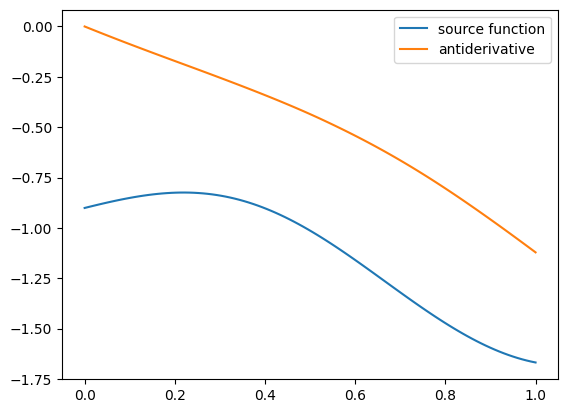

In [106]:
plt.plot(trunk_input_train[:, 0], branch_input_train[0, :], label="source function")
plt.plot(trunk_input_train[:, 0], output_train[0, :], label="antiderivative")
plt.legend()
plt.show()

In [107]:
branch_input_train.shape, trunk_input_train.shape, output_train.shape

((150, 100), (100, 1), (150, 100))

dataloader to batch over branch network i.e. batch over pairs of (source function, antiderivative)

In [108]:
def dataloader(arrays, batch_size):
    dataset_size = arrays[0].shape[0]
    assert all(array.shape[0] == dataset_size for array in arrays)
    indices = np.arange(dataset_size)
    while True:
        perm = np.random.permutation(indices)
        start = 0
        end = batch_size
        while end <= dataset_size:
            batch_perm = perm[start:end]
            yield tuple(array[batch_perm] for array in arrays)
            start = end
            end = start + batch_size

main training loop

In [111]:
def main(
    batch_size=32,
    learning_rate=3e-3,
    steps=10000,
    layer_sizes_branch=[100, 64, 32],
    layers_sizes_trunk=[1, 64, 32],
    activation=jax.nn.relu,
    seed=SEED
):
    key = jr.key(seed)

    # dataloader
    iter_data = dataloader([branch_input_train, output_train], batch_size)

    # define model
    model = DeepONet(layer_sizes_branch, layers_sizes_trunk, activation, key, jnp.float32)

    # define loss
    @eqx.filter_value_and_grad
    def compute_loss(model, x_branch, x_trunk, y):
        preds = jax.vmap(jax.vmap(model, in_axes=(None, 0)), in_axes=(0, None))(x_branch, x_trunk)
        return jnp.mean((preds - y)**2)
    
    # step function
    @eqx.filter_jit
    def make_step(model, x_branch, x_trunk, y, opt_state):
        loss, grads = compute_loss(model, x_branch, x_trunk, y)
        updates, opt_state = optim.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        return loss, model, opt_state

    # define optimiser
    optim = optax.adam(learning_rate)
    opt_state = optim.init(eqx.filter(model, eqx.is_array))

    # training loop
    losses = []
    for step, (x_branch, y) in zip(range(steps), iter_data):
        loss, model, opt_state = make_step(model, x_branch, trunk_input_train, y, opt_state)
        losses.append(loss.item())
        if step % int(0.1*steps) == 0:
            print(f"step={step}, loss={losses[step]}")
    print(f"Final loss: {losses[-1]}")

    # plot loss and example prediction
    _, ax = plt.subplots(1, 2, figsize=(12, 6.75))
    ax[0].semilogy(losses)
    ax[1].plot(trunk_input_test[:, 0], branch_input_test[0, :], label="source function")
    ax[1].plot(trunk_input_test[:, 0], output_test[0, :], label="true antiderivative")
    ax[1].plot(trunk_input_test[:, 0], jax.vmap(model, in_axes=(None, 0))(branch_input_test[0, :], trunk_input_test), label="predicted antiderivative")
    plt.legend()
    plt.tight_layout()
    plt.show()

step=0, loss=0.29434388875961304
step=500, loss=2.895103898481466e-05
step=1000, loss=1.5249495845637284e-05
step=1500, loss=0.0002359817735850811
step=2000, loss=1.6622843759250827e-05
step=2500, loss=0.00033473147777840495
step=3000, loss=7.726402145635802e-06
step=3500, loss=8.480936230625957e-06
step=4000, loss=3.6376652587932767e-06
step=4500, loss=8.758622425375506e-05
Final loss: 2.740780018939404e-06


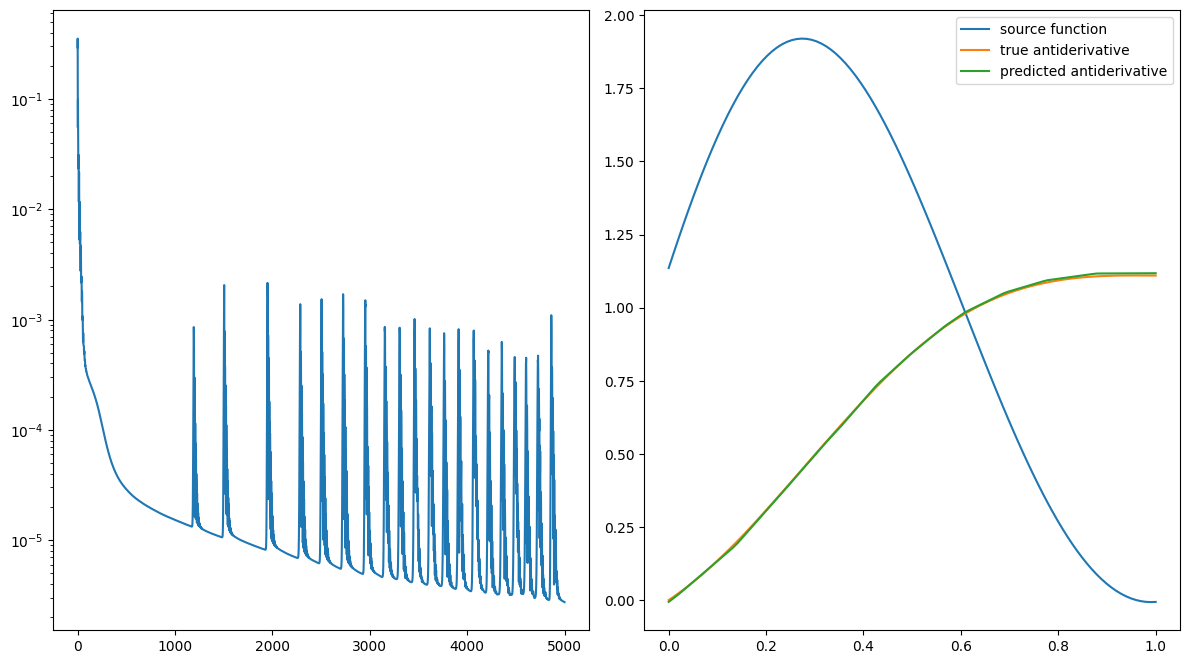

In [113]:
main(batch_size=150, steps=5000)